In [1]:
!pip install -Uqq fastcore accelerate transformers diffusers

In [2]:
from PIL import Image
import numpy as np
import torch
from torch import nn, tensor
from torchvision.transforms import ToTensor
from fastcore.all import *

In [3]:
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [4]:
from diffusers.models import UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

In [5]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16).to('cuda')
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet', torch_dtype=torch.float16).to('cuda')

Let's inspect the unet structure a bit:

In [6]:
len(unet.down_blocks), len(unet.up_blocks)

(4, 4)

In [7]:
L(unet.down_blocks[0].named_children()).itemgot(0)

(#3) ['attentions','resnets','downsamplers']

In [8]:
unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1

Attention(
  (to_q): Linear(in_features=320, out_features=320, bias=False)
  (to_k): Linear(in_features=320, out_features=320, bias=False)
  (to_v): Linear(in_features=320, out_features=320, bias=False)
  (to_out): ModuleList(
    (0): Linear(in_features=320, out_features=320, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

In [9]:
unet.down_blocks[0].attentions[0].transformer_blocks[0].attn2

Attention(
  (to_q): Linear(in_features=320, out_features=320, bias=False)
  (to_k): Linear(in_features=768, out_features=320, bias=False)
  (to_v): Linear(in_features=768, out_features=320, bias=False)
  (to_out): ModuleList(
    (0): Linear(in_features=320, out_features=320, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

Out text embedding has size `768`. It seems it's only used in `attn2` for the `k` and `v` projection

___

In [10]:
txt_tok = tokenizer('bla', return_tensors='pt', padding='max_length').input_ids.to('cuda')
txt_emb = text_encoder(txt_tok)[0].half()
rand_lat = torch.rand((1,4,64,64)).to('cuda').half()

In [11]:
with torch.no_grad(): outp = unet(rand_lat, 2, encoder_hidden_states=txt_emb)[0]

In [12]:
outp.shape

torch.Size([1, 4, 64, 64])

Running the unet works
___

In [13]:
from diffusers.models.attention_processor import AttnProcessor2_0

Next, let's replace the attention processors

In [14]:
class KnowledgeableAttnProcessor2_0(AttnProcessor2_0):
    def __init__(self, name):
        super().__init__()
        self.name = name

    def __call__(self, *args, **kwargs):
        print(f'My name? It is {self.name}. Imma do some attending now.')
        return super().__call__(*args, **kwargs)

In [15]:
unet.set_attn_processor({
    k: KnowledgeableAttnProcessor2_0(name=k)
    for k,v in unet.attn_processors.items()
})

In [16]:
with torch.no_grad(): outp = unet(rand_lat, 2, encoder_hidden_states=txt_emb)

My name? It is down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor. Imma do some attending now.
My name? It is down_blocks.0.attentions.0.transformer_blocks.0.attn2.processor. Imma do some attending now.
My name? It is down_blocks.0.attentions.1.transformer_blocks.0.attn1.processor. Imma do some attending now.
My name? It is down_blocks.0.attentions.1.transformer_blocks.0.attn2.processor. Imma do some attending now.
My name? It is down_blocks.1.attentions.0.transformer_blocks.0.attn1.processor. Imma do some attending now.
My name? It is down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor. Imma do some attending now.
My name? It is down_blocks.1.attentions.1.transformer_blocks.0.attn1.processor. Imma do some attending now.
My name? It is down_blocks.1.attentions.1.transformer_blocks.0.attn2.processor. Imma do some attending now.
My name? It is down_blocks.2.attentions.0.transformer_blocks.0.attn1.processor. Imma do some attending now.
My name? It is down_blocks.2

Cool! I can now change attention processors for each attention block individually!

___

Let's now implement P2P.<br/>
Luckily, Weifeng Chen already implemented it [here](https://github.com/Weifeng-Chen/prompt2prompt/). Let's understand his code.

In [17]:
def view_images(images, num_rows=1, offset_ratio=0.02, display_image=True) -> Image.Image:
    """ Displays a list of images in a grid. """
    if type(images) is list: num_empty = len(images) % num_rows
    elif images.ndim == 4: num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0
    
    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    if display_image: display(pil_img)
    return pil_img

In [18]:
import abc

class AttentionControl(abc.ABC):
    def step_callback(self, x_t): return x_t
    def between_steps(self): return
    @property
    def num_uncond_att_layers(self): return 0
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str): raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            h = attn.shape[0]   
            attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet) 
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

In [19]:
class AttentionStore(AttentionControl):
    @staticmethod
    def get_empty_store(): return {"down_cross": [], "mid_cross": [], "up_cross": [], "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2: self.step_store[key].append(attn) # avoid memory overhead
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0: self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])): self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self): return {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
    
    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

In [20]:
from typing import Callable, List, Optional, Union
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline, StableDiffusionPipelineOutput

# todo:
# need to add negative prompting?
# and prompt_embeds (=pass already encoded prompt text, not text itself)?
# 
class Prompt2PromptPipeline(StableDiffusionPipeline):
    _optional_components = ["safety_checker", "feature_extractor"]

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: Optional[int] = None,
        width: Optional[int] = None,
        controller: AttentionStore = None,  # todo: don't pass in controller, but use cross_attention_kwargs
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
    ):
        self.register_attention_control(controller) # add attention controller
        height,width = (height or self.unet.config.sample_size * self.vae_scale_factor, width or self.unet.config.sample_size * self.vae_scale_factor) # 0. Default height and width to unet
        self.check_inputs(prompt, height, width, callback_steps) # 1. Check inputs. Raise error if not correct

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        # following lines are missing:
        # text_encoder_lora_scale = (
        #   cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        # )
        text_embeddings = self._encode_prompt(prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt)
        
        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.in_channels
        latents = self.prepare_latents( batch_size * num_images_per_prompt, num_channels_latents, height, width, text_embeddings.dtype, device, generator, latents,)

        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta) # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample # predict the noise residual
                if do_classifier_free_guidance:  # perform guidance
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                # following lines are missing:
                # if do_classifier_free_guidance and guidance_rescale > 0.0:
                #     # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                #     noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample # compute the previous noisy sample x_t -> x_t-1
                latents = controller.step_callback(latents)  # step callback
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0): # call the callback, if provided
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0: callback(i, t, latents)
        image = self.decode_latents(latents) # 8. Post-processing
        image, has_nsfw_concept = self.run_safety_checker(image, device, text_embeddings.dtype) # 9. Run safety checker
        if output_type == "pil": image = self.numpy_to_pil(image) # 10. Convert to PIL
        if not return_dict: return (image, has_nsfw_concept)
        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

    def register_attention_control(self, controller):
        attn_procs = {}
        cross_att_count = 0
        for name in self.unet.attn_processors.keys():
            # comment Umer: we seem to only using the 2nd attn in each attn block
            cross_attention_dim = None if name.endswith("attn1.processor") else self.unet.config.cross_attention_dim

            if name.startswith("mid_block"):
                hidden_size = self.unet.config.block_out_channels[-1]
                place_in_unet = "mid"
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(self.unet.config.block_out_channels))[block_id]
                place_in_unet = "up"
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = self.unet.config.block_out_channels[block_id]
                place_in_unet = "down"
            else:
                continue
            cross_att_count += 1
            attn_procs[name] = P2PCrossAttnProcessor(
                controller=controller, place_in_unet=place_in_unet
            )

        self.unet.set_attn_processor(attn_procs)
        controller.num_att_layers = cross_att_count

In [21]:
from diffusers.models.cross_attention import CrossAttention

class P2PCrossAttnProcessor:
    def __init__(self, controller, place_in_unet):
        super().__init__()
        self.controller = controller
        self.place_in_unet = place_in_unet

    def __call__(self, attn: CrossAttention, hidden_states, encoder_hidden_states=None, attention_mask=None):
        batch_size, sequence_length, _ = hidden_states.shape
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        query = attn.to_q(hidden_states)

        is_cross = encoder_hidden_states is not None
        encoder_hidden_states = encoder_hidden_states if encoder_hidden_states is not None else hidden_states
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        
        self.controller(attention_probs, is_cross, self.place_in_unet) # one line change

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)
        hidden_states = attn.to_out[0](hidden_states) # linear proj
        hidden_states = attn.to_out[1](hidden_states) # dropout
        return hidden_states

/opt/conda/lib/python3.10/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [22]:
class AttentionControlEdit(AttentionStore, abc.ABC):
    def step_callback(self, x_t):
        if self.local_blend is not None: x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2: return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else: return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace): raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        # FIXME not replace correctly
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else: attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend,
                 tokenizer,
                 device):
        super(AttentionControlEdit, self).__init__()
        # add tokenizer and device here

        self.tokenizer = tokenizer
        self.device = device

        self.batch_size = len(prompts)
        self.cross_replace_alpha = get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, self.tokenizer).to(self.device)
        if type(self_replace_steps) is float: self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend  # 在外面定义后传进来

In [23]:
def get_time_words_attention_alpha(prompts, num_steps,
                                   cross_replace_steps: Union[float, Dict[str, Tuple[float, float]]],
                                   tokenizer, max_num_words=77):
    if type(cross_replace_steps) is not dict: cross_replace_steps = {"default_": cross_replace_steps}
    if "default_" not in cross_replace_steps: cross_replace_steps["default_"] = (0., 1.)
    alpha_time_words = torch.zeros(num_steps + 1, len(prompts) - 1, max_num_words)
    for i in range(len(prompts) - 1):
        alpha_time_words = update_alpha_time_word(alpha_time_words, cross_replace_steps["default_"],
                                                  i)
    for key, item in cross_replace_steps.items():
        if key != "default_":
             inds = [get_word_inds(prompts[i], key, tokenizer) for i in range(1, len(prompts))]
             for i, ind in enumerate(inds):
                 if len(ind) > 0: alpha_time_words = update_alpha_time_word(alpha_time_words, item, i, ind)
    alpha_time_words = alpha_time_words.reshape(num_steps + 1, len(prompts) - 1, 1, 1, max_num_words)
    return alpha_time_words

In [24]:
def update_alpha_time_word(alpha, bounds: Union[float, Tuple[float, float]], prompt_ind: int,
                           word_inds: Optional[torch.Tensor]=None):
    if type(bounds) is float: bounds = 0, bounds
    start, end = int(bounds[0] * alpha.shape[0]), int(bounds[1] * alpha.shape[0])
    if word_inds is None: word_inds = torch.arange(alpha.shape[2])
    alpha[: start, prompt_ind, word_inds] = 0
    alpha[start: end, prompt_ind, word_inds] = 1
    alpha[end:, prompt_ind, word_inds] = 0
    return alpha

In [25]:
def get_replacement_mapper_(x: str, y: str, tokenizer, max_len=77):
    words_x,words_y = x.split(' '), y.split(' ')
    if len(words_x) != len(words_y): raise ValueError(f"Prompts need same lengths, but are {len(words_x)} and {len(words_y)} words.")
    inds_replace = [i for i in range(len(words_y)) if words_y[i] != words_x[i]]
    inds_source = [get_word_inds(x, i, tokenizer) for i in inds_replace]
    inds_target = [get_word_inds(y, i, tokenizer) for i in inds_replace]
    mapper = np.zeros((max_len, max_len))
    i = j = 0
    cur_inds = 0
    while i < max_len and j < max_len:
        if cur_inds < len(inds_source) and inds_source[cur_inds][0] == i:
            inds_source_, inds_target_ = inds_source[cur_inds], inds_target[cur_inds]
            if len(inds_source_) == len(inds_target_):
                mapper[inds_source_, inds_target_] = 1
            else:
                ratio = 1 / len(inds_target_)
                for i_t in inds_target_: mapper[inds_source_, i_t] = ratio
            cur_inds += 1
            i += len(inds_source_)
            j += len(inds_target_)
        elif cur_inds < len(inds_source):
            mapper[i, j] = 1
            i += 1
            j += 1
        else:
            mapper[j, j] = 1
            i += 1
            j += 1
    return torch.from_numpy(mapper).float()

def get_replacement_mapper(prompts, tokenizer, max_len=77):
    x_seq = prompts[0]
    mappers = []
    for i in range(1, len(prompts)):
        mapper = get_replacement_mapper_(x_seq, prompts[i], tokenizer, max_len)
        mappers.append(mapper)
    return torch.stack(mappers)

In [26]:
def get_word_inds(text: str, word_place: int, tokenizer):
    split_text = text.split(" ")
    if type(word_place) is str: word_place = [i for i, word in enumerate(split_text) if word_place == word]
    elif type(word_place) is int: word_place = [word_place]
    out = []
    if len(word_place) > 0:
        words_encode = [tokenizer.decode([item]).strip("#") for item in tokenizer.encode(text)][1:-1]
        cur_len, ptr = 0, 0

        for i in range(len(words_encode)):
            cur_len += len(words_encode[i])
            if ptr in word_place: out.append(i + 1)
            if cur_len >= len(split_text[ptr]):
                ptr += 1
                cur_len = 0
    return np.array(out)

In [27]:
stuff = {} # to play around with stuff inside AttentionReplace

class AttentionReplace(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend = None, tokenizer=None, device=None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend, tokenizer, device)
        self.mapper = get_replacement_mapper(prompts, self.tokenizer).to(self.device)

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        #### Save inputs to play with later ###
        stuff['self'],stuff['attn'],stuff['is_cross'],stuff['place_in_unet'] = self, attn, is_cross, place_in_unet
        ### ### ### ### ### ### ### ### ### ###
        return super(AttentionReplace, self).forward(attn, is_cross, place_in_unet)

In [28]:
device = 'cuda'
g_cpu = torch.Generator().manual_seed(2333)
prompts = ['A painting of a squirrel eating a burger',
           'A painting of a cat eating a burger']
NUM_DIFFUSION_STEPS = 20

In [29]:
pipe = Prompt2PromptPipeline.from_pretrained("CompVis/stable-diffusion-v1-4" )

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [30]:
controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=0.4, self_replace_steps=0.4, tokenizer=pipe.tokenizer, device=pipe.device)

In [31]:
outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS, controller=controller, generator=g_cpu)

/tmp/ipykernel_206/1219369344.py:51: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/20 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:422: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


(**Weird** that the same code works for the first 2 times, and then not anymore.)

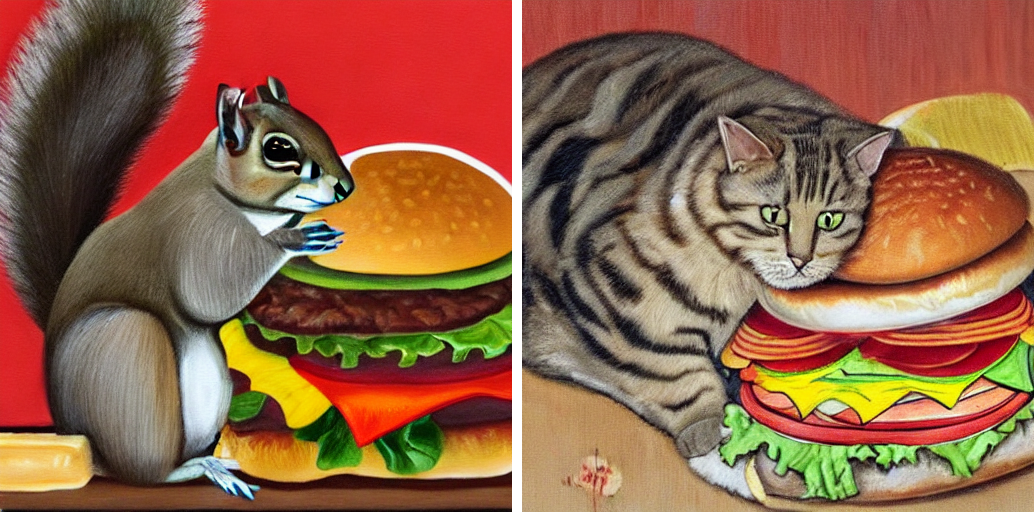

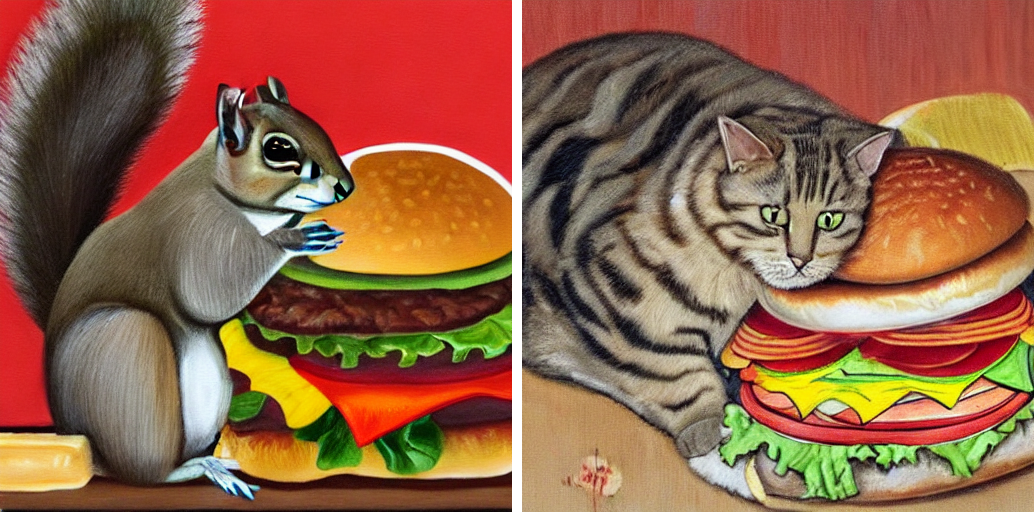

In [32]:
view_images([np.array(img) for img in outputs.images])

(**Weird** that this prompts generates supposedly NSFW content, when using 10 steps.)

___

But we're interested in playing around with the attention control, to understand the code better. Therefore let's continue

In [33]:
stuff.keys()

dict_keys(['self', 'attn', 'is_cross', 'place_in_unet'])

In [34]:
my_cls_attn_replace = stuff['self']

In [35]:
AttentionReplace.mro()

[__main__.AttentionReplace,
 __main__.AttentionControlEdit,
 __main__.AttentionStore,
 __main__.AttentionControl,
 abc.ABC,
 object]

In [36]:
AttentionReplace.forward??

Signature: AttentionReplace.forward(self, attn, is_cross: bool, place_in_unet: str)
Docstring: <no docstring>
Source:   
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        #### Save inputs to play with later ###
        stuff['self'],stuff['attn'],stuff['is_cross'],stuff['place_in_unet'] = self, attn, is_cross, place_in_unet
        ### ### ### ### ### ### ### ### ### ###
        return super(AttentionReplace, self).forward(attn, is_cross, place_in_unet)
File:      /tmp/ipykernel_206/1968828346.py
Type:      function

In [37]:
AttentionControlEdit.forward??

Signature:
AttentionControlEdit.forward(
    self,
    attn,
    is_cross: bool,
    place_in_unet: str,
)
Docstring: <no docstring>
Source:   
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        # FIXME not replace correctly
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else: attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch

In [38]:
AttentionStore.forward??

Signature: AttentionStore.forward(self, attn, is_cross: bool, place_in_unet: str)
Docstring: <no docstring>
Source:   
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2: self.step_store[key].append(attn) # avoid memory overhead
        return attn
File:      /tmp/ipykernel_206/1072263060.py
Type:      function

In [39]:
AttentionControl.forward??

Signature: AttentionControl.forward(self, attn, is_cross: bool, place_in_unet: str)
Docstring: <no docstring>
Source:   
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str): raise NotImplementedError
File:      /tmp/ipykernel_206/672357487.py
Type:      function

In [40]:
my_cls_attn_replace.step_store

{'down_cross': [],
 'mid_cross': [],
 'up_cross': [],
 'down_self': [],
 'mid_self': [],
 'up_self': []}

In [41]:
stuff['is_cross'], stuff['place_in_unet']

(True, 'up')

In [42]:
my_attn = stuff['attn']
my_attn.shape

torch.Size([16, 4096, 77])

In [43]:
my_cls_attn_replace.cur_step, my_cls_attn_replace.cross_replace_alpha.shape

(21, torch.Size([21, 1, 1, 1, 77]))

In [44]:
for i in range(my_cls_attn_replace.cross_replace_alpha.shape[0]):
    print(my_cls_attn_replace.cross_replace_alpha[i].flatten())

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
t

`cross_replace_alpha` seems to control how much replacement we do. At first, we replace fully, then not at all. This makes sense, as only the first steps are necessary to fix the composition.

Here's the self-attention replacement:

In [45]:
my_cls_attn_replace.replace_self_attention??

Signature: my_cls_attn_replace.replace_self_attention(attn_base, att_replace)
Docstring: <no docstring>
Source:   
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2: return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else: return att_replace
File:      /tmp/ipykernel_206/3690686970.py
Type:      method

In [46]:
# att_replace.shape[0], *attn_base.shape
my_attn_base, my_attn_replace = my_attn[0], my_attn[1:]
my_attn_base.shape, my_attn_replace.shape, my_attn.shape

(torch.Size([4096, 77]),
 torch.Size([15, 4096, 77]),
 torch.Size([16, 4096, 77]))

In [47]:
my_attn_base.unsqueeze(0).shape

torch.Size([1, 4096, 77])

In [48]:
my_attn_base.unsqueeze(0).expand(my_attn_replace.shape[0], *my_attn_base.shape).shape

torch.Size([15, 4096, 77])

Note: The expansions seem unnecessary, as `my_attn_base.unsqueeze(0)` makes `my_attn_base` broadcast-able with `my_attn_replace`

Here's the cross-attention replacement:

In [49]:
my_cls_attn_replace.replace_cross_attention??

Signature: my_cls_attn_replace.replace_cross_attention(attn_base, att_replace)
Docstring: <no docstring>
Source:   
    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
File:      /tmp/ipykernel_206/1968828346.py
Type:      method

In [50]:
my_attn_base.shape, my_cls_attn_replace.mapper.shape

(torch.Size([4096, 77]), torch.Size([1, 77, 77]))

In [51]:
#torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)

In [52]:
get_replacement_mapper_('a dog', 'a cat', tokenizer)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Let's understand `get_replacement_mapper_` better by running it with logs

In [53]:
def get_replacement_mapper_(x: str, y: str, tokenizer, max_len=77):
    words_x,words_y = x.split(' '), y.split(' ')
    if len(words_x) != len(words_y): raise ValueError(f"Prompts need same lengths, but are {len(words_x)} and {len(words_y)} words.")
    inds_replace = [i for i in range(len(words_y)) if words_y[i] != words_x[i]]
    inds_source = [get_word_inds(x, i, tokenizer) for i in inds_replace]
    inds_target = [get_word_inds(y, i, tokenizer) for i in inds_replace]
    mapper = np.zeros((max_len, max_len))
    i = j = 0
    cur_inds = 0

    print(f'inds_replace: {inds_replace}')
    print(f'inds_source: {inds_source}')
    print(f'inds_target: {inds_target}')
    
    while i < max_len and j < max_len:
        if cur_inds < len(inds_source) and inds_source[cur_inds][0] == i:
            inds_source_, inds_target_ = inds_source[cur_inds], inds_target[cur_inds]
            print(f'>> inds_source_, inds_target_ = {inds_source_}, {inds_target_}')
            if len(inds_source_) == len(inds_target_):
                mapper[inds_source_, inds_target_] = 1
                print(f'Setting mapper[inds_source_, inds_target_ = {inds_source_}, {inds_target_}] to 1')
            else:
                ratio = 1 / len(inds_target_)
                for i_t in inds_target_:
                    mapper[inds_source_, i_t] = ratio                
                    print(f'> Setting mapper[inds_source_, i_t = {inds_source_}, {i_t}] to ratio ({ratio})')
            cur_inds += 1
            i += len(inds_source_)
            j += len(inds_target_)
            print(f'Incrementing i by len(inds_source_)={len(inds_source_)} & j by len(inds_target_)={len(inds_target_)}')
        elif cur_inds < len(inds_source):
            print(f'Setting mapper[i,j={i},{j}] to 1, as cur_inds ({cur_inds}) < len(inds_source)=({len(inds_source)}) || Incrementing i & j by 1')
            mapper[i, j] = 1
            i += 1
            j += 1
        else:
            print(f'Setting mapper[j,i={j},{i}] to 1 (else case) || Incrementing i & j by 1')
            mapper[j, j] = 1
            i += 1
            j += 1
    return torch.from_numpy(mapper).float()

In [54]:
ba_dog, ba_blts = 'a big ass dog with a hat', 'a big ass blastoise with a hat'
tokenizer(ba_dog), tokenizer(ba_blts)

({'input_ids': [49406, 320, 1205, 5301, 1929, 593, 320, 3801, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [49406, 320, 1205, 5301, 2205, 928, 1479, 593, 320, 3801, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

In [55]:
[tokenizer.decode([t]) for t in [2205, 928, 1479]]

['bla', 'sto', 'ise']

I understand how the mapper works (see `Mapper.ipynb`)

___

I want to understand the shapes of the cross-attention layer. The attention controllers I looked at above don't computethe attention itself, but just modify it.<br/>
The attention computation itself is done in `P2PCrossAttnProcessor`.

In [56]:
my_attn_base.shape

torch.Size([4096, 77])

Let's first build a class that saves all variables we want

In [94]:
class LoggedVars:
    def __init__(self): self.variables = {}
    def __setitem__(self,k,v): self.variables[k] =  v.detach().to('cpu').clone() if hasattr(v,'detach') else v
    def __getitem__(self, k): return self.variables[k] 
    def __getattr__(self,k): return self.variables[k]
    def keys(self): return self.variables.keys()
    def items(self): return self.variables.items()
    def clear(self): return self.variables.clear()

In [58]:
my_vars = LoggedVars()
my_vars['two'] = 2
my_vars['two'],my_vars.two

(2, 2)

In [59]:
my_gpu_var = tensor([24]).to('cuda')
my_gpu_var

tensor([24], device='cuda:0')

In [60]:
my_vars['gpu_24'] = my_gpu_var
my_vars.gpu_24

tensor([24])

Okay, works.

Let's adapt `P2PCrossAttnProcessor` so the attention application is recorded, and let's adapt `AttentionReplace` so the attention control application is recorded.

In [61]:
mv = LoggedVars()

class P2PCrossAttnProcessor:
    def __init__(self, controller, place_in_unet):
        super().__init__()
        self.controller = controller
        self.place_in_unet = place_in_unet

    def __call__(self, attn: CrossAttention, hidden_states, encoder_hidden_states=None, attention_mask=None):
        mv.clear()
        
        mv['attn'] = attn
        mv['hidden_states__passed'] = hidden_states
        mv['encoder_hidden_states__passed'] = encoder_hidden_states
        mv['attention_mask__passed'] = attention_mask
        
        batch_size, sequence_length, _ = hidden_states.shape
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
        mv['batch_size'] = batch_size
        mv['sequence_length'] = sequence_length
        mv['attn#prepare_attention_mask'] = attn.prepare_attention_mask
        mv['attention_mask'] = attention_mask
        
        query = attn.to_q(hidden_states)

        is_cross = encoder_hidden_states is not None
        encoder_hidden_states = encoder_hidden_states if encoder_hidden_states is not None else hidden_states
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)
        mv['query__pre_h2b'] = query
        mv['is_cross'] = is_cross
        mv['encoder_hidden_states'] = encoder_hidden_states
        mv['key__pre_h2b'] = key
        mv['value__pre_h2b'] = value

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)
        mv['query'] = query
        mv['key'] = key
        mv['value'] = value
        
        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        mv['attention_probs__precontrol'] = attention_probs
        mv['attn#get_attention_scores'] = attn.get_attention_scores
        
        self.controller(attention_probs, is_cross, self.place_in_unet) # one line change
        mv['attention_probs__postcontrol'] = attention_probs
        mv['place_in_unet'] = self.place_in_unet
        
        hidden_states = torch.bmm(attention_probs, value)
        mv['hidden_states_1'] = hidden_states
        hidden_states = attn.batch_to_head_dim(hidden_states)
        mv['hidden_states_2'] = hidden_states
        hidden_states = attn.to_out[0](hidden_states) # linear proj
        mv['hidden_states_3'] = hidden_states
        hidden_states = attn.to_out[1](hidden_states) # dropout
        mv['hidden_states_4'] = hidden_states

        mv['attn#to_out'] = attn.to_out
        mv['attn#head_to_batch_dim'] = attn.head_to_batch_dim
        mv['attn#batch_to_head_dim'] = attn.batch_to_head_dim
        
        return hidden_states

In [62]:
mv_controller = LoggedVars()

class AttentionReplace(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend = None, tokenizer=None, device=None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend, tokenizer, device)
        self.mapper = get_replacement_mapper(prompts, self.tokenizer).to(self.device)

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        #### Save inputs to play with later ###
        mv_controller.clear()
        mv_controller['mapper'] = self.mapper
        mv_controller['self'] = self
        mv_controller['attn'] = attn
        mv_controller['is_cross'] = is_cross
        mv_controller['place_in_unet'] = place_in_unet
        ### ### ### ### ### ### ### ### ### ###
        return super(AttentionReplace, self).forward(attn, is_cross, place_in_unet)

In [63]:
pipe = Prompt2PromptPipeline.from_pretrained("CompVis/stable-diffusion-v1-4" )

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [64]:
controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=0.4, self_replace_steps=0.4, tokenizer=pipe.tokenizer, device=pipe.device)

inds_replace: [4]
inds_source: [array([5])]
inds_target: [array([5])]
Setting mapper[i,j=0,0] to 1, as cur_inds (0) < len(inds_source)=(1) || Incrementing i & j by 1
Setting mapper[i,j=1,1] to 1, as cur_inds (0) < len(inds_source)=(1) || Incrementing i & j by 1
Setting mapper[i,j=2,2] to 1, as cur_inds (0) < len(inds_source)=(1) || Incrementing i & j by 1
Setting mapper[i,j=3,3] to 1, as cur_inds (0) < len(inds_source)=(1) || Incrementing i & j by 1
Setting mapper[i,j=4,4] to 1, as cur_inds (0) < len(inds_source)=(1) || Incrementing i & j by 1
>> inds_source_, inds_target_ = [5], [5]
Setting mapper[inds_source_, inds_target_ = [5], [5]] to 1
Incrementing i by len(inds_source_)=1 & j by len(inds_target_)=1
Setting mapper[j,i=6,6] to 1 (else case) || Incrementing i & j by 1
Setting mapper[j,i=7,7] to 1 (else case) || Incrementing i & j by 1
Setting mapper[j,i=8,8] to 1 (else case) || Incrementing i & j by 1
Setting mapper[j,i=9,9] to 1 (else case) || Incrementing i & j by 1
Setting mappe

In [65]:
outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS, controller=controller, generator=g_cpu)

/tmp/ipykernel_206/1219369344.py:51: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/20 [00:00<?, ?it/s]

In [66]:
mv.keys()

dict_keys(['attn', 'hidden_states__passed', 'encoder_hidden_states__passed', 'attention_mask__passed', 'batch_size', 'sequence_length', 'attn#prepare_attention_mask', 'attention_mask', 'query__pre_h2b', 'is_cross', 'encoder_hidden_states', 'key__pre_h2b', 'value__pre_h2b', 'query', 'key', 'value', 'attention_probs__precontrol', 'attn#get_attention_scores', 'attention_probs__postcontrol', 'place_in_unet', 'hidden_states_1', 'hidden_states_2', 'hidden_states_3', 'hidden_states_4', 'attn#to_out', 'attn#head_to_batch_dim', 'attn#batch_to_head_dim'])

Okay, recording worked. Now we can look at the shapes of every relevant matrix:

In [67]:
mv.batch_size, mv.sequence_length, mv.hidden_states__passed.shape, mv.encoder_hidden_states__passed.shape, mv.attention_mask__passed

(4, 4096, torch.Size([4, 4096, 320]), torch.Size([4, 77, 768]), None)

In [68]:
print(mv.attention_mask)

None


In [69]:
print(mv['attn#prepare_attention_mask'](mv.attention_mask__passed, mv.sequence_length, mv.batch_size))

None


In [70]:
mv.is_cross

True

In [71]:
mv.query__pre_h2b.shape, mv.key__pre_h2b.shape, mv.value__pre_h2b.shape

(torch.Size([4, 4096, 320]),
 torch.Size([4, 77, 320]),
 torch.Size([4, 77, 320]))

In [72]:
mv.query.shape, mv.key.shape, mv.value.shape

(torch.Size([32, 4096, 40]),
 torch.Size([32, 77, 40]),
 torch.Size([32, 77, 40]))

In [73]:
mv.attention_probs__precontrol.shape

torch.Size([32, 4096, 77])

In [74]:
mv.place_in_unet

'up'

In [75]:
print('Hidden states')

descrs = [
    'initially', 'after b2h',
    'afer linear projection', 'after dropout'
]

for i,d in enumerate(descrs):
    print(d, ':', mv[f'hidden_states_{i+1}'].shape)

Hidden states
initially : torch.Size([32, 4096, 40])
after b2h : torch.Size([4, 4096, 320])
afer linear projection : torch.Size([4, 4096, 320])
after dropout : torch.Size([4, 4096, 320])


In [76]:
type(mv_controller.mapper)

torch.Tensor

In [77]:
mv_controller.mapper.shape

torch.Size([1, 77, 77])

In [78]:
mv_controller.attn.shape

torch.Size([16, 4096, 77])

___

In [88]:
import pickle

with open('cache/mv_attention.pkl', 'wb') as f:
    pickle.dump(mv, f)

with open('cache/mv_attention_controller.pkl', 'wb') as f:
    pickle.dump(mv_controller, f)

with open('cache/prompts.pkl', 'wb') as f:
    pickle.dump(prompts, f)

___

In [90]:
def do_tok(o): return tokenizer(o).input_ids
def undo_tok(o): return [tokenizer.decode(t) for t in o]

In [91]:
def show_tokenization(txt):
    tok_nums = do_tok(txt)
    tok_words= undo_tok(tok_nums)

    for i, (n,w) in enumerate(zip(tok_nums, tok_words)):
        print(f'#{i}: {n} -> {w}')

In [92]:
show_tokenization(prompts[0])

#0: 49406 -> <|startoftext|>
#1: 320 -> a
#2: 3086 -> painting
#3: 539 -> of
#4: 320 -> a
#5: 14004 -> squirrel
#6: 4371 -> eating
#7: 320 -> a
#8: 6548 -> burger
#9: 49407 -> <|endoftext|>


So, tokens `10` to `77` will be dummies.

In [100]:
mv.attention_probs__precontrol.shape

torch.Size([32, 4096, 77])

In [121]:
import matplotlib.pyplot as plt
def show_attn_map(am, tok_idx):
    attn_im = am[:,:,tok_idx].sum(axis=0).reshape(64,64)
    plt.title(f'Average attention map for text token at index {tok_idx}')
    plt.imshow(attn_im)
    plt.show();

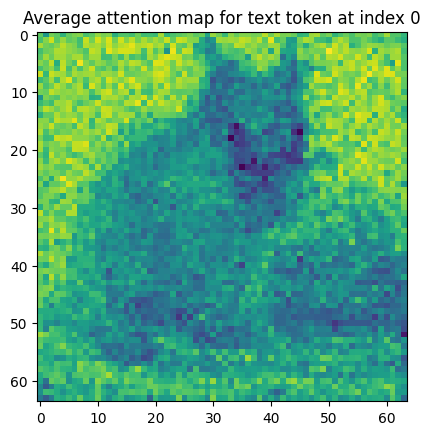

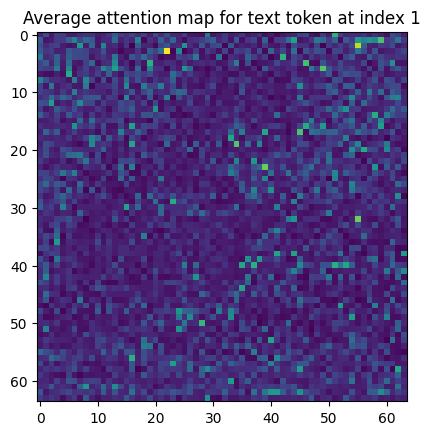

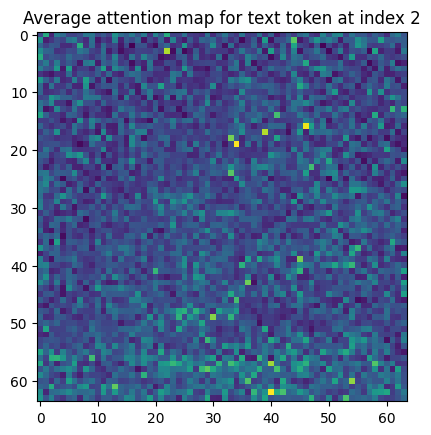

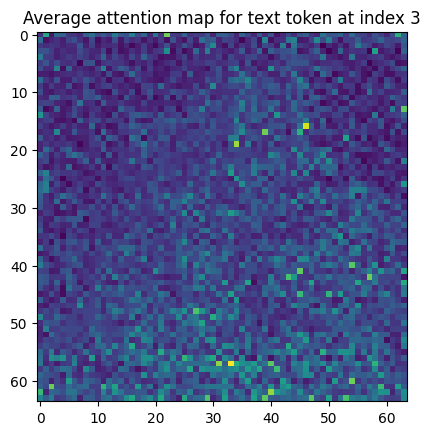

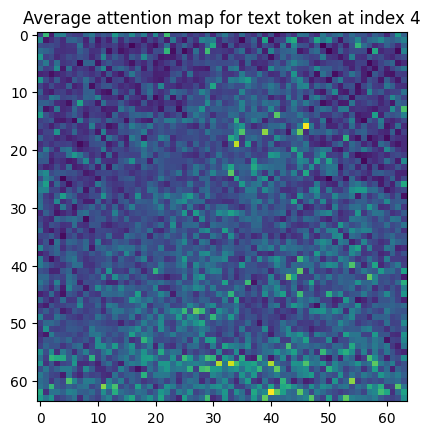

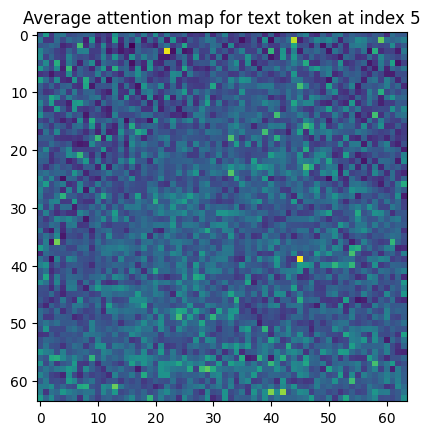

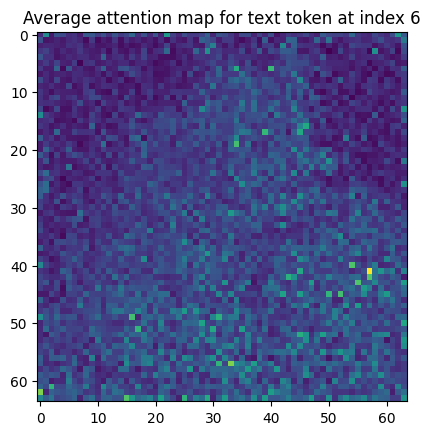

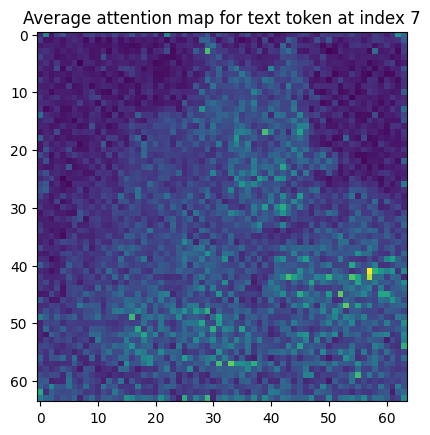

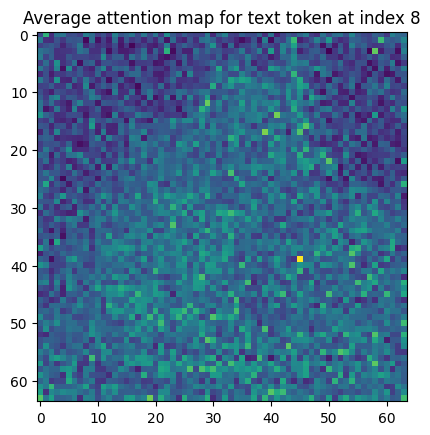

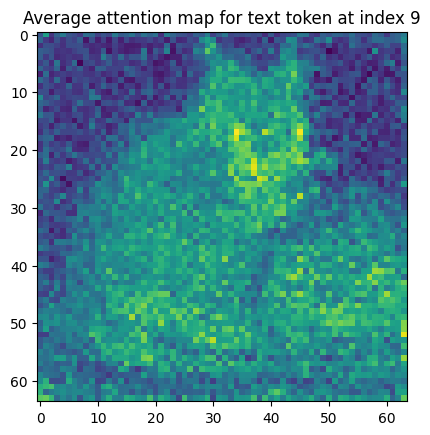

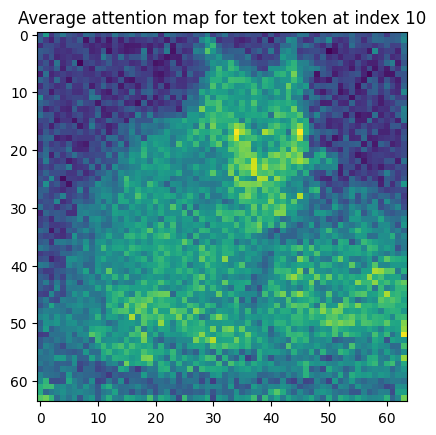

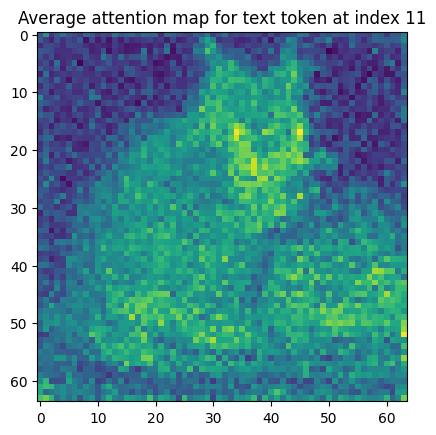

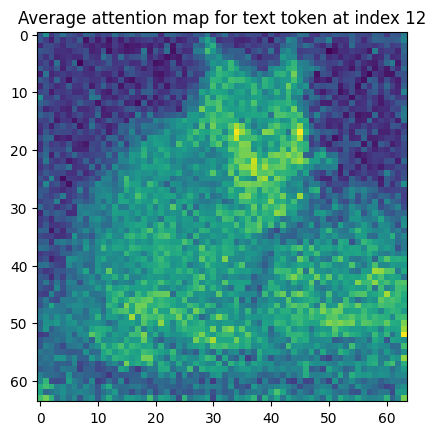

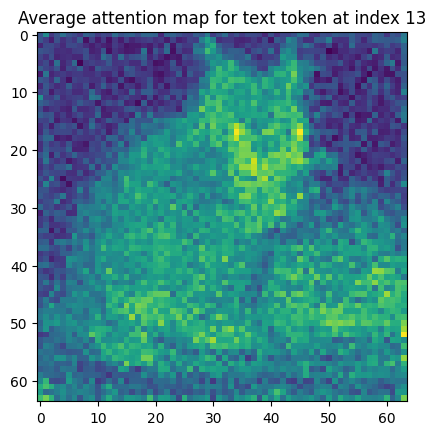

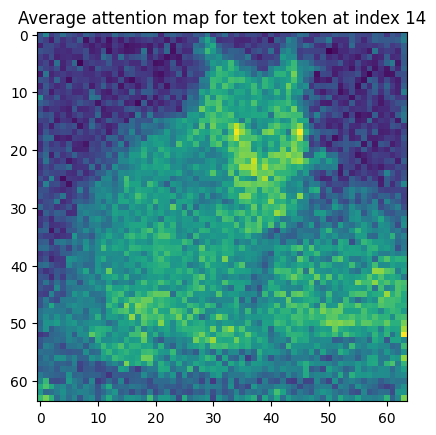

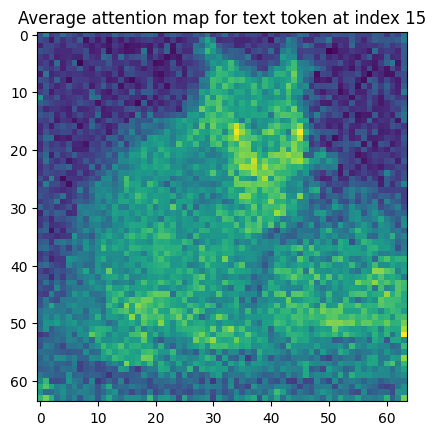

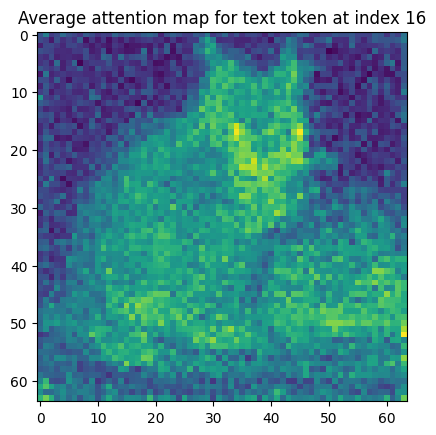

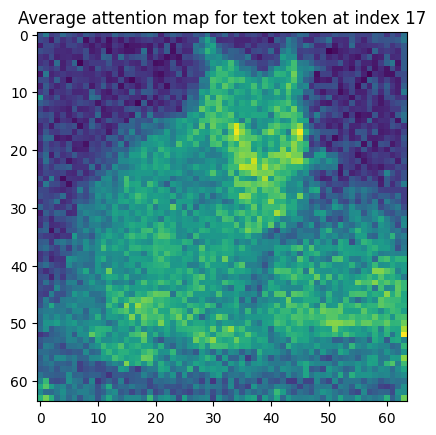

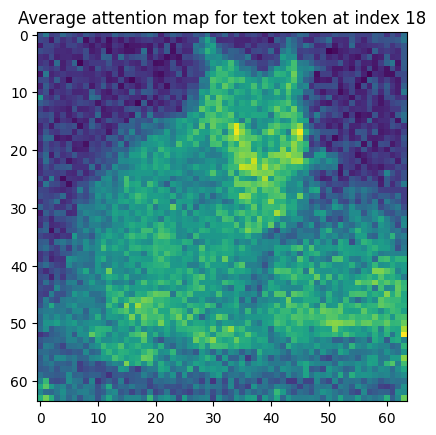

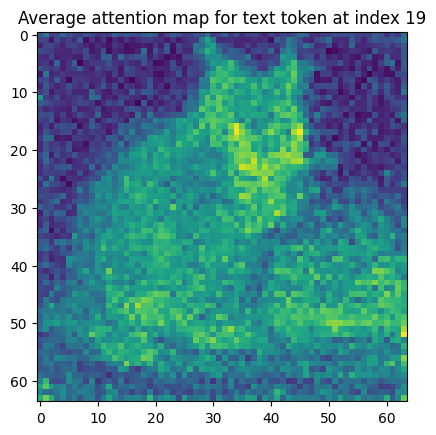

In [122]:
for i in range(20):
    show_attn_map(mv.attention_probs__precontrol, i)